<a href="https://colab.research.google.com/github/Vishal64B/Computer-Vision/blob/main/2347264_CV_Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Define paths to the video and image
VIDEO_PATH = "video.mp4"
IMAGE_PATH = "image.jpg"

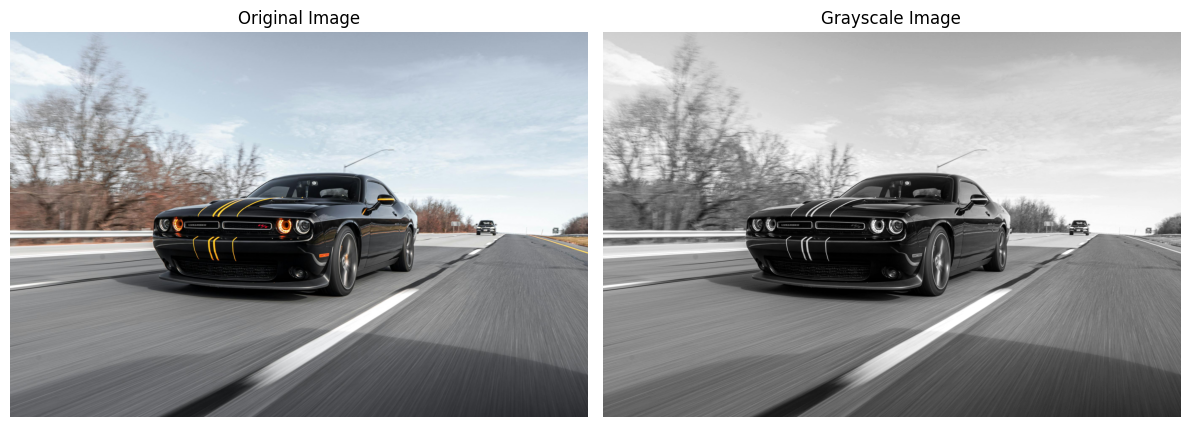

Original image dimensions: (1825, 2738, 3)
Grayscale image dimensions: (1825, 2738)


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray

# Load the original image
car_image = cv2.imread(IMAGE_PATH)
# Convert BGR to RGB for proper display in matplotlib
car_image_rgb = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)

# Convert image to grayscale using skimage
gray_image = rgb2gray(io.imread(IMAGE_PATH))

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(car_image_rgb)
plt.title("Original Image")
plt.axis('off')

# Display grayscale image
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print image dimensions for reference
print(f"Original image dimensions: {car_image.shape}")
print(f"Grayscale image dimensions: {gray_image.shape}")

###Static Image Segmentation:
- Implement the active contour (snakes) model to segment an object within a single static image.
- Initialize a contour around the object and allow it to evolve toward the object&#39;s boundaries.

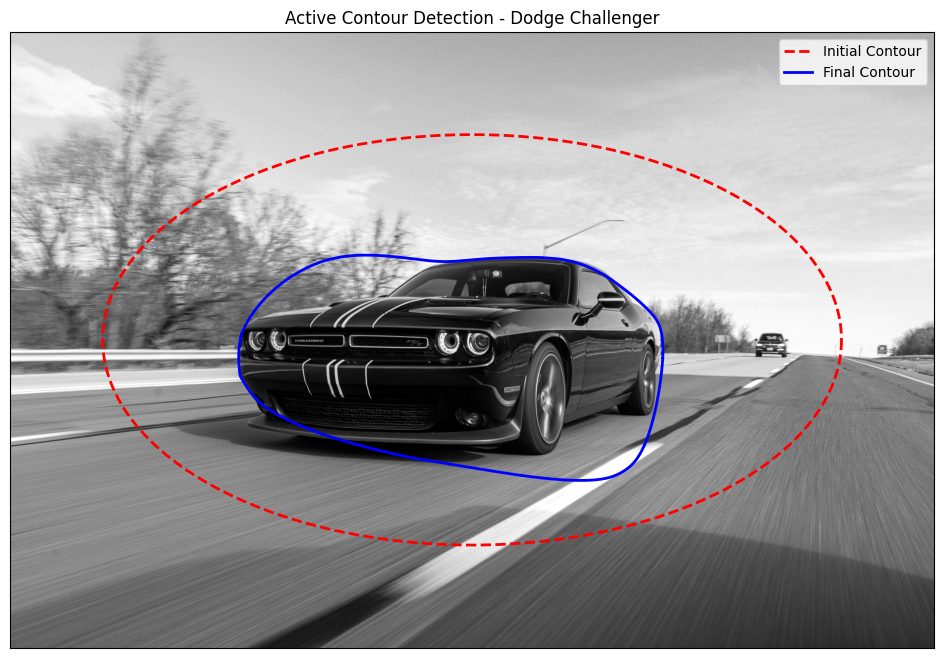

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Load and convert image to grayscale
img = rgb2gray(io.imread('image.jpg'))

# The car is roughly centered in the image and takes up a significant portion
# Adjust center and radius to match the car's position
center_row, center_col = img.shape[0] // 2, img.shape[1] // 2
radius = min(img.shape) // 3  # Adjusted to better fit the car's size

# Create more points for better detail around the car
num_points = 600
s = np.linspace(0, 2*np.pi, num_points)

# Initialize with an ellipse instead of a circle to better match car shape
width_factor = 1.8  # Car is wider than it is tall
r = center_row + radius * np.sin(s)
c = center_col + radius * width_factor * np.cos(s)
init = np.array([r, c]).T

# Adjusted parameters for better edge detection without max_iterations
snake = active_contour(
    gaussian(img, sigma=2, preserve_range=False),  # Reduced sigma for sharper edges
    init,
    alpha=0.015,  # Slightly increased elasticity
    beta=10,      # Increased rigidity to maintain smooth car curves
    gamma=0.001   # Reduced for slower but more accurate convergence
)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=2, label='Initial Contour')
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=2, label='Final Contour')
ax.set_xticks([])
ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
ax.legend(loc='upper right')
plt.title('Active Contour Detection - Dodge Challenger')

plt.show()

###Dynamic Video Segmentation :
-  Extend the implementation to segment the same object in a video.
- Initialize the contour in the first frame, then continuously update the contour for each frame
to adapt to any changes in the object’s position, size, or shape.
- Display the evolving contour in real-time on the video.

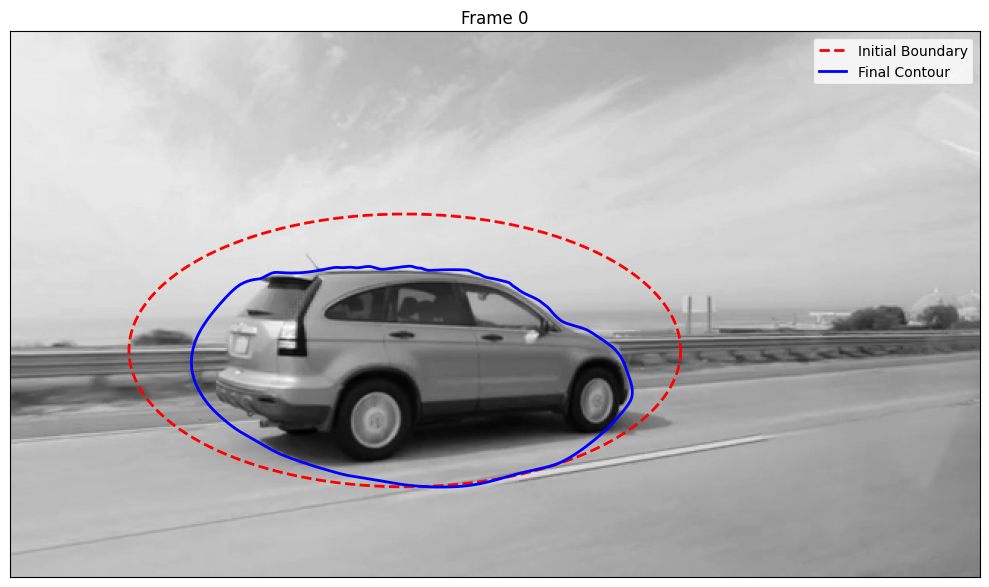

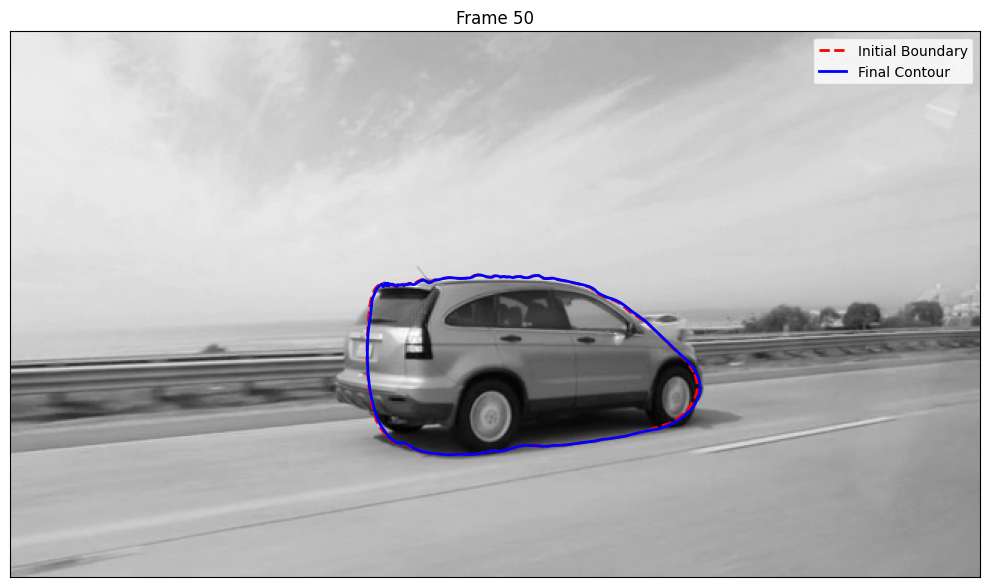

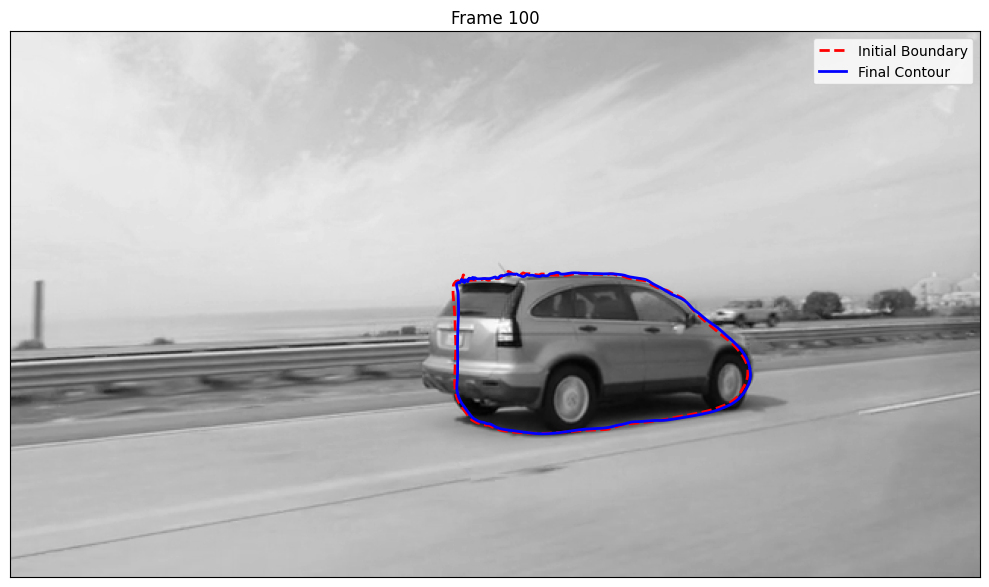

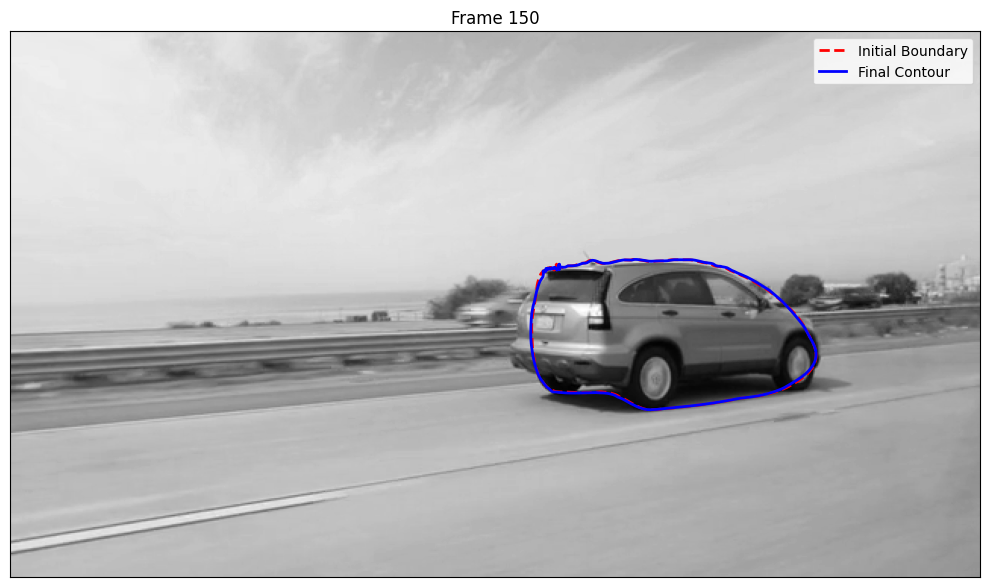

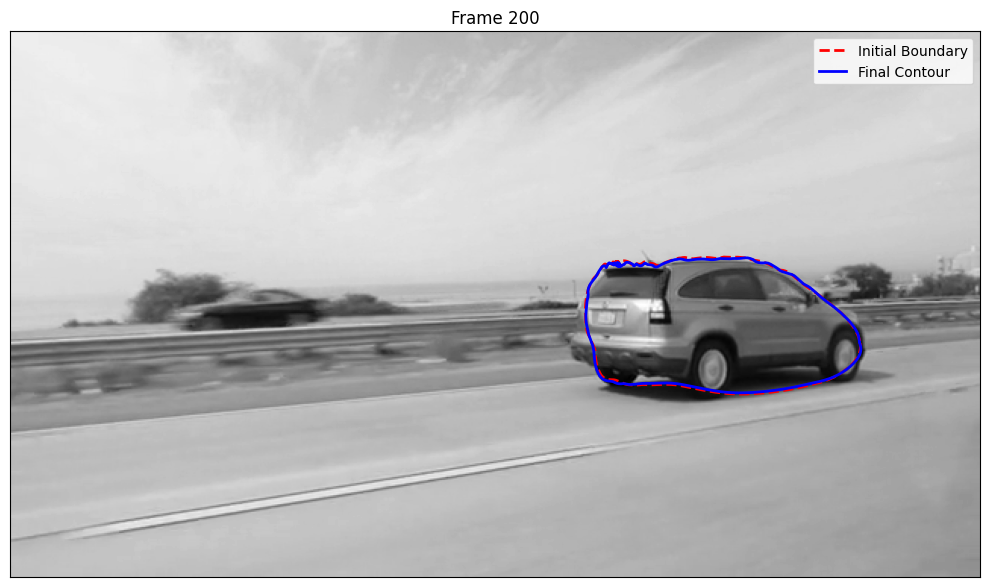

Processing completed. Video saved as contour_tracking_output.mp4.


In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian, sobel
from skimage.segmentation import active_contour
from skimage.exposure import adjust_gamma

# Load the video
video_path = 'video.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Parameters
frame_interval = 50  # Display every 50th frame
max_frames = 230     # Stop after 230 frames
frame_count = 0

# Initialize snake on the first frame
ret, first_frame = cap.read()
if not ret:
    print("Error: Could not read the first frame.")
    cap.release()
    exit()

# Get video properties for output video
frame_height, frame_width = first_frame.shape[:2]
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Output video writer setup
output_video_path = 'contour_tracking_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Convert first frame to grayscale and initialize contour
first_gray = rgb2gray(first_frame)
first_gray = adjust_gamma(first_gray, 1.5)
edges = sobel(first_gray)
img_processed = gaussian(edges, sigma=1.5)

# Initialize contour based on the first frame dimensions
rows, cols = first_gray.shape
s = np.linspace(0, 2 * np.pi, 420)

center_row = rows // 2 + 30  # Adjust vertical center
center_col = cols // 2 - 60   # Adjust horizontal center
height = rows // 4            # Adjust height of ellipse
width = cols // 3.5           # Adjust width of ellipse

r = center_row + height * np.sin(s)
c = center_col + width * np.cos(s)
init = np.array([r, c]).T

# Loop through the video
while True:
    ret, frame = cap.read()

    if not ret or frame_count >= max_frames:
        break

    # Convert the current frame to grayscale
    gray_frame = rgb2gray(frame)

    # Enhance and process the frame
    gray_enhanced = adjust_gamma(gray_frame, 1.5)
    edges = sobel(gray_enhanced)
    img_processed = gaussian(edges, sigma=1.5)

    # Apply active contour (snake)
    snake = active_contour(
        img_processed,
        init,
        alpha=0.015,    # Smoothness
        beta=10,      # Rigidity
        gamma=0.001,  # Step size
    )

    # Display and save the frame with contour overlay
    if frame_count % frame_interval == 0:
        plt.figure(figsize=(10, 6))
        plt.imshow(gray_frame, cmap=plt.cm.gray)
        plt.plot(init[:, 1], init[:, 0], '--r', lw=2, label='Initial Boundary')
        plt.plot(snake[:, 1], snake[:, 0], '-b', lw=2, label='Final Contour')
        plt.title(f'Frame {frame_count}')
        plt.xticks([])
        plt.yticks([])
        plt.legend()
        plt.tight_layout()
        plt.show()  # Display frame

    # Draw the final contour on the frame
    for i in range(len(snake) - 1):
        cv2.line(frame,
                 (int(snake[i, 1]), int(snake[i, 0])),
                 (int(snake[i + 1, 1]), int(snake[i + 1, 0])),
                 (255, 0, 0), 2)  # Draw blue contour

    # Save the frame with the contour to the output video
    out.write(frame)

    # Update the initial contour for the next frame
    init = snake.copy()

    # Increment frame count
    frame_count += 1

# Release video capture and writer
cap.release()
out.release()
print("Processing completed. Video saved as contour_tracking_output.mp4.")